# Predictions on Time Series with Prescience

The best way to understand how to make prediction on timeseries in `Prescience` is probably to do it with an example. For that purpose we are going to use a time serie that traces the evolution in number of bytes of a Ceph cluster usage.

The source is already uploaded.

## The `source` object

We uploaded the raw data from a time serie backend (Warp10) and started a `parse task`. This task includes some pre-analysis on the raw data for later processing and some type resolution.

The `source` object is almost like your original data, except that it holds some metadata inside that have been computed during the parse tasks. We wont describe all the metadata here but this is several statistics like :
* The standard deviation for each column
* The type of data contained in the column (integer, boolean, text, etc...)
* If the column can contains `null` values
* etc...

Let's retrieve the existing sources

In [1]:
from prescience_client import prescience
# Display the list of all sources in your prescience project
prescience.sources().show('html')

,source_id,status,input_type,info
0,iris,BUILT,CSV,None
1,ceph-usage-40w-hourly,BUILT,TIME_SERIE,None


Then we get back this source to explore it and get a brief summary of what informations were extracted during the `parse task`.

In [2]:
source = prescience.source('ceph-usage-40w-hourly')
source.schema().show('html')

,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,time-column,long,False,6721,None,None,1.549372e+15,1561449600000000,True
1,ceph_usage_total_used_bytes,double,True,0,None,None,2.166504e+14,None,True


We can even plot the source object to visualize the raw timeserie. To do so we need to indicate the name of the column we want to use as abscisse `x`.

Directory '/home/jovyan/.prescience/cache' doesn't exists. Creating it...
Directory '/home/jovyan/.prescience/cache/sources' doesn't exists. Creating it...
Updating cache for source 'ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/sources/ceph-usage-40w-hourly


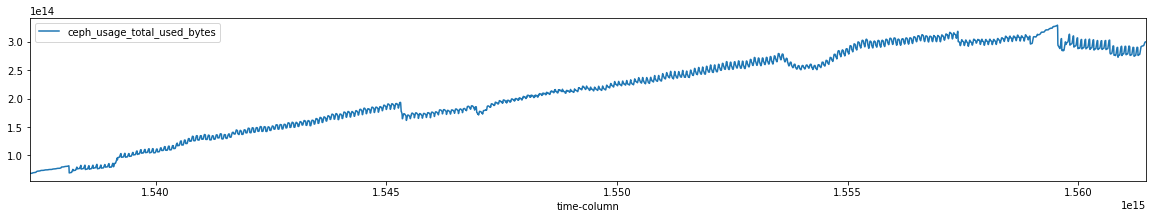

In [3]:
%matplotlib inline
import matplotlib
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)
source.plot(x='time-column')

### The dataset object

The `dataset` object contains the same data than in your `source` except that this data has been transformed so that it can be understandable by machine learning algorithms.

The rules of transformation won't be described here but all you have to know is that previously computed statistics are used to choose the good transformation strategy.

In our case if we plot the dataset we will see that it looks exactly the same as the source, except that all axis have been standardized (i.e values have been rescaled and bound with 0 as the mean)

Directory '/home/jovyan/.prescience/cache/datasets' doesn't exists. Creating it...
Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/train' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/train


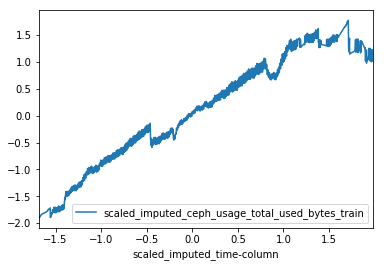

In [4]:
dataset_id = 'dataset-ceph-usage-40w-hourly'
prescience.plot_dataset(dataset_id, plot_test=False)

The `dataset` object is created from a `source` with a `preprocess task`. Another things to note is that the preprocess task is responsible for creating the `folds` that we previously talk about on `Problem Definition` part.

You wan easily see created `folds` :

Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/0/train' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/0/train
Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/0/test' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/0/test


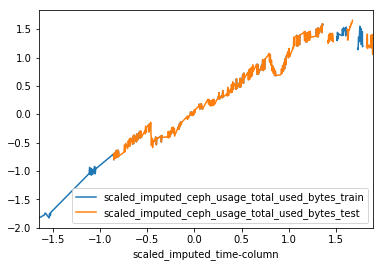

Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/1/train' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/1/train
Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/1/test' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/1/test


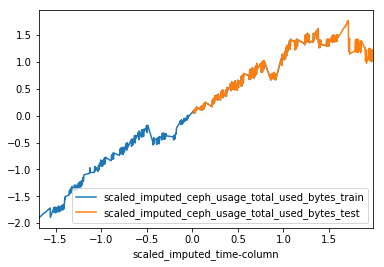

Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/2/train' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/2/train
Directory '/home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/2/test' doesn't exists. Creating it...
Updating cache for source 'dataset-ceph-usage-40w-hourly' : /home/jovyan/.prescience/cache/datasets/dataset-ceph-usage-40w-hourly/fold/2/test


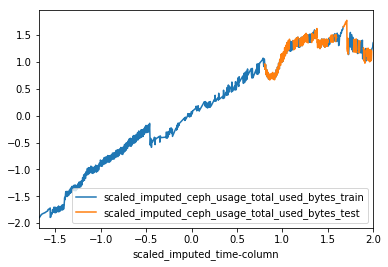

In [5]:
for fold_number in range(3):
    prescience.plot_dataset(dataset_id, fold_number=fold_number)

As you can see, each fold is composed of 2 parts :
* A train part which is used to train machine learning algorithms
* A test part which is used to evalute the relevance of a model

It is a standard process in machine learning in order to evaluate relevancy of machine learning algorithms on data that they have never seen before.

### The model object

The `model` object is created from a `dataset` with a `train task` however a train task needs to be launched on a specific machine learning algorithm with defined parameters. That's why there is an intermediate task which is called the `optimization task`.

The aim of an optimization task is to use the previously created folds of our dataset to train a lot of machine learning algorithms with different hyperparameters, evaluate them and find the best.

All results of evaluations are stored in prescience into objects called `evaluations results`. You can request the visualisation of previously computed evaluation by doing so :

In [6]:
evaluation_results = prescience.get_evaluation_results(
    dataset_id,
    # Only display results for the wanted horizon
    forecasting_horizon_steps=24,
    # Sort all the results by the selected scoring metric
    sort_column=f'costs.mse'
)
evaluation_results.show('html')

,uuid,status,config_name,past_steps,horizon,discount,r2_cost,mae_cost,mse_cost
0,40e48dec-992d-43ff-9a70-31d6fd4faf8d,BUILT,skridgeregression,16,24,1.0,-0.953,0.053,0.008
1,74ecc93a-f407-48e1-a467-95499424edbd,BUILT,skridgeregression,12,24,1.0,-0.952,0.054,0.008
2,e4f2638a-2aef-4993-b719-6c6f453ade4e,BUILT,skridgeregression,15,24,1.0,-0.952,0.053,0.009
3,d7a3f59b-a657-4db1-b9eb-def9c797be63,BUILT,skridgeregression,17,24,1.0,-0.952,0.052,0.009
4,c38da62c-258d-4f84-86a0-647f83a28dfe,BUILT,skridgeregression,27,24,1.0,-0.950,0.052,0.009
5,f05c2167-5b9b-40cb-90cc-6bcc16fc87e0,BUILT,skridgeregression,30,24,1.0,-0.943,0.053,0.010
6,3f10cfcd-46f5-44a6-af95-aa3ae6048842,BUILT,mlp_for_time_series,15,24,1.0,-0.930,0.070,0.013
7,a7ad2cd8-90f4-46fd-a0b5-d556e3986a78,BUILT,skridgeregression,57,24,1.0,-0.936,0.062,0.013
8,4f74b819-c359-477c-88e6-eb4ac132c0a9,BUILT,lstm_for_time_series,49,24,1.0,-0.910,0.078,0.014
9,12bc6441-a0b1-49a4-809d-0e5de77f16e3,BUILT,skridgeregression,53,24,1.0,-0.910,0.060,0.014


The first row of the table is the best model and configuration find. If we compare this configuration with the configuration of the model deployed we will see that they are the same.

In [7]:
# Show the config from the best evaluation results
config_eval = evaluation_results.content[0].config()

import json
print(json.dumps(config_eval.kwargs(), indent=4))

config_eval.show('html')

{
    "alpha": 0.19681934964249728,
    "normalize": "False",
    "past_steps": 16,
    "fit_intercept": "True",
    "forecasting_discount": 1.0,
    "forecasting_horizon_steps": 24
}


,,CONFIG attributes
0,name,skridgeregression
1,display_name,Ridge Regression
2,class_identifier,linear_model.Ridge
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'alpha': 0.19681934964249728, 'normalize': 'F..."


## Play around with the model

We previously trained a model automatically tuned by prescience. It's forecast horizon was set to 24 (the base serie being sampled with an interval of 1 hour) to predict a day forward.

In [8]:
# Display the list of all models associated to this source
source.tree().show()

Source(ceph-usage-40w-hourly)
 +-- Dataset(dataset-ceph-usage-40w-hourly)
     +-- Model(ceph-usage-40w-hourly-model-24hori)


In [9]:
# Access the created model on prescience
model_id = 'ceph-usage-40w-hourly-model-24hori'
model = prescience.model(model_id)

# Show the config from the model
config_train = model.config()
print(json.dumps(config_train.kwargs(), indent=4))
config_train.show('html')

{
    "alpha": 0.19681934964249728,
    "normalize": "False",
    "past_steps": 16,
    "fit_intercept": "True",
    "forecasting_discount": 1.0,
    "forecasting_horizon_steps": 24
}


,,CONFIG attributes
0,name,skridgeregression
1,display_name,Ridge Regression
2,class_identifier,linear_model.Ridge
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'alpha': 0.19681934964249728, 'normalize': 'F..."


## Observing predictions results
Ploting the predicted result of a model is one of the best way to estimate its relevancy. We are going to choose some arbitrary points in our original data and compare the theorical serie with the predicted one from newly deployed model.

In [10]:
ORIGIN_TIMESTAMP = 1560733200000000

# Generate the input payload that will be send to the model for making prediction (it use the initial data to create it)
payload_dict = prescience.generate_payload_dict_for_model(model_id, from_data=ORIGIN_TIMESTAMP)

# Print this payload :
import json
print(json.dumps(payload_dict, indent=4))

Cache for source 'ceph-usage-40w-hourly' is already up to date on /home/jovyan/.prescience/cache/sources/ceph-usage-40w-hourly
Directory '/home/jovyan/.prescience/cache/payload' doesn't exists. Creating it...
Saving json into `/home/jovyan/.prescience/cache/payload/payload.json`
{
    "time-column": [
        1560679200000000,
        1560682800000000,
        1560686400000000,
        1560690000000000,
        1560693600000000,
        1560697200000000,
        1560700800000000,
        1560704400000000,
        1560708000000000,
        1560711600000000,
        1560715200000000,
        1560718800000000,
        1560722400000000,
        1560726000000000,
        1560729600000000,
        1560733200000000
    ],
    "ceph_usage_total_used_bytes": [
        303391551077636.3,
        303376296463286.9,
        292132378156349.8,
        281063696641631.47,
        279981661734707.2,
        279053739924548.28,
        279293759474551.47,
        279553697033352.53,
        2793382789

### Ask for a single prediction

Cache for source 'ceph-usage-40w-hourly' is already up to date on /home/jovyan/.prescience/cache/sources/ceph-usage-40w-hourly


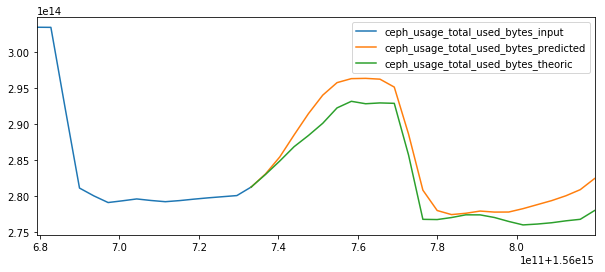

In [11]:
# Get the prediction of the model
result_dataframe = model.get_dataframe_for_plot_result(payload_dict)

# Plot the prediction of the model
matplotlib.pyplot.rcParams["figure.figsize"] = (10, 4)
result_dataframe.plot()

### Ask for a rolling prediction
We can go a bit further and ask the model to predict even further in the past, the prediction result is used as input for the next forecast. 

Rolling forecasts tend to be less and less accurate. Usually either the result converges to a fixed value or diverges abruptly.

Let's see how this model handles the rolling prediction.

Cache for source 'ceph-usage-40w-hourly' is already up to date on /home/jovyan/.prescience/cache/sources/ceph-usage-40w-hourly


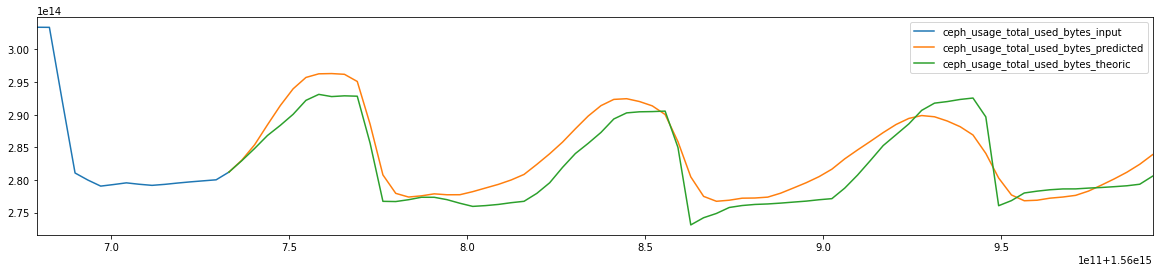

In [12]:
# Get the prediction of the model with a 'rolling' strategy
result_dataframe = model.get_dataframe_for_plot_result(payload_dict, rolling_steps=2)

# Plot the prediction of the model
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 4)
result_dataframe.plot()

As you can see, it seems that the deployed model unsterstood the trend and the seasonality of the underlying time-series. It is a first step, however predictions can be improved. We are going to see what is really happening under the hood and try to improve that prediction.

What would happen if we went even further ?

Cache for source 'ceph-usage-40w-hourly' is already up to date on /home/jovyan/.prescience/cache/sources/ceph-usage-40w-hourly


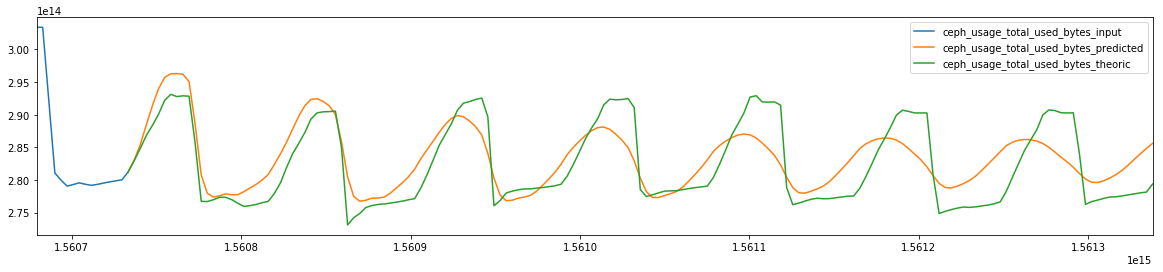

In [13]:
# Get the prediction of the model with a 'rolling' strategy
result_dataframe = model.get_dataframe_for_plot_result(payload_dict, rolling_steps=6)

# Plot the prediction of the model
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 4)
result_dataframe.plot()

The prediction seems to maintain the seasonality with a lower variance and with an increasing trend.